## Prediction of Density of States (DOS) using Partial Radial Distribution Function (PRDF) 

We want to study the accuracy and time performance of the featurizations used in [Schutt et al paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118). Here in part 2, we build an ML model and analyze accuracy of the method. 

#### Import packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV

#### Load featurized data from pickle file

In [2]:
path = os.path.join(os.getcwd(), 'schutt_cutoff16_binsize10.pkl')
data = pd.read_pickle(path)

In [3]:
print ("Shape of data: ", data.shape)
data.head(1)

Shape of data:  (4829, 38644)


,material_id,structure_obj,max_orbital,dos,Cs-Cs PRDF r=0.00-1.00,Cs-Cs PRDF r=1.00-2.00,Cs-Cs PRDF r=2.00-3.00,Cs-Cs PRDF r=3.00-4.00,Cs-Cs PRDF r=4.00-5.00,Cs-Cs PRDF r=5.00-6.00,...,Ne-Ne PRDF r=6.00-7.00,Ne-Ne PRDF r=7.00-8.00,Ne-Ne PRDF r=8.00-9.00,Ne-Ne PRDF r=9.00-10.00,Ne-Ne PRDF r=10.00-11.00,Ne-Ne PRDF r=11.00-12.00,Ne-Ne PRDF r=12.00-13.00,Ne-Ne PRDF r=13.00-14.00,Ne-Ne PRDF r=14.00-15.00,Ne-Ne PRDF r=15.00-16.00
0,mp-85,[[0. 0. 0.] In],spd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Count sp and spd systems

In [4]:
count = data['max_orbital'].value_counts(sort=True)
count

spd    4600
sp      229
Name: max_orbital, dtype: int64

Partition compounds into $sp$ and $spd$ systems.

In Schutt's paper, there are 1716 sp systems and 5548 spd systems.

In [5]:
data = data.sort_values(by=['max_orbital'])

In [6]:
sp_data = data[:count['sp']]
spd_data = data[count['sp']:]
print ("sp systems: ", sp_data.shape[0])
print ("spd systems: ", spd_data.shape[0])

sp systems:  229
spd systems:  4600


Input X and Y

In [7]:
x_sp = sp_data.drop(['material_id', 'structure_obj', 'max_orbital', 'dos'], 1)
y_sp = sp_data['dos']
x_sp, y_sp = shuffle(x_sp, y_sp)

In [8]:
x_spd = spd_data.drop(['material_id', 'structure_obj', 'max_orbital', 'dos'], 1)
y_spd = spd_data['dos']
x_spd, y_spd = shuffle(x_spd, y_spd)

Partition data into training and testing set (80/20)

In [9]:
x_train = {"sp": x_sp[:int(0.8*x_sp.shape[0])], "spd": x_spd[:int(0.8*x_spd.shape[0])]}
x_test = {"sp": x_sp[int(0.8*x_sp.shape[0]):], "spd": x_spd[int(0.8*x_spd.shape[0]):]}
y_train = {"sp": y_sp[:int(0.8*y_sp.shape[0])], "spd": y_spd[:int(0.8*y_spd.shape[0])]}
y_test = {"sp": y_sp[int(0.8*y_sp.shape[0]):], "spd": y_spd[int(0.8*y_spd.shape[0]):]}

### Build ML model

Set up Kernel Ridge Regression (KRR) model. Three types of kernel: linear, Gaussian, Laplacian

In [10]:
kernels = ['linear', 'gaussian', 'laplacian']

In [11]:
sp_models = {"linear": KernelRidge(kernel="linear"), "gaussian": KernelRidge(kernel="rbf"), "laplacian": KernelRidge(kernel="laplacian")}
spd_models = {"linear": KernelRidge(kernel="linear"), "gaussian": KernelRidge(kernel="rbf"), "laplacian": KernelRidge(kernel="laplacian")}

Here we'll compare the performance of three different kernels in predicting DOS for sp and spd systems.

In [12]:
kfold = KFold(5)

In [13]:
cv_prediction_sp, cv_prediction_spd = dict.fromkeys(kernels), dict.fromkeys(kernels)

In [14]:
for key in sp_models:
    sp_models[key] = sp_models[key].fit(x_train['sp'], y_train['sp'])
    cv_prediction_sp[key] = cross_val_predict(sp_models[key], x_test['sp'], y_test['sp'], cv=kfold)

In [15]:
for key, val in spd_models.items():
    spd_models[key] = val.fit(x_train['spd'], y_train['spd'])
    cv_prediction_spd[key] = cross_val_predict(spd_models[key], x_test['spd'], y_test['spd'], cv=kfold)

Compute aggregate statistics of the kernels used.

In [16]:
metrics = ['mean_absolute_error', 'mean_squared_error', 'r2_score']
score_sp, score_spd = dict.fromkeys(kernels), dict.fromkeys(kernels)
for i, j in zip(score_sp, score_spd):
    score_sp[i], score_sp[j] = dict.fromkeys(metrics), dict.fromkeys(metrics)

In [17]:
for model in ['linear', 'gaussian', 'laplacian']:
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_sp[model][scorer] = getattr(metrics, scorer)(y_test['sp'], cv_prediction_sp[model])
        score_spd[model][scorer] = getattr(metrics, scorer)(y_test['spd'], cv_prediction_spd[model])

In [18]:
print ("sp system score: ")
for i in score_sp:
    print (i, ": ", score_sp[i])
print ()
print ("spd system score: ")
for i in score_spd:
    print (i, ": ", score_spd[i])

sp system score: 
linear :  {'mean_absolute_error': 0.0007054000113079487, 'mean_squared_error': 2.5633873077217162e-06, 'r2_score': -0.18073958183066763}
gaussian :  {'mean_absolute_error': 0.000899048817759862, 'mean_squared_error': 2.3956482719474926e-06, 'r2_score': -0.1034761428021096}
laplacian :  {'mean_absolute_error': 0.0008990327442432902, 'mean_squared_error': 2.3956349495271374e-06, 'r2_score': -0.10347000626979885}

spd system score: 
linear :  {'mean_absolute_error': 0.0011501964695632351, 'mean_squared_error': 3.982065016980835e-06, 'r2_score': -0.16581063414324815}
gaussian :  {'mean_absolute_error': 0.0012554285785216996, 'mean_squared_error': 3.417103109578141e-06, 'r2_score': -0.00040936703001359653}
laplacian :  {'mean_absolute_error': 0.0012552301391384332, 'mean_squared_error': 3.4163738208809417e-06, 'r2_score': -0.00019585657377296783}


Plot prediction

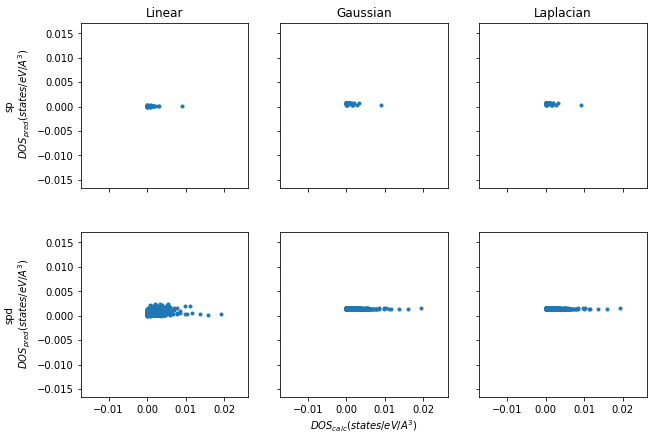

In [38]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)

ax[0, 0].set_title("Linear")
ax[0, 1].set_title("Gaussian")
ax[0, 2].set_title("Laplacian")

ax[0, 0].set_ylabel("sp\n $DOS_{pred} (states/eV/A^3)$")
ax[1, 0].set_ylabel("spd\n $DOS_{pred} (states/eV/A^3)$")
ax[1, 1].set_xlabel("$DOS_{calc} (states/eV/A^3)$")

ax[0, 0].scatter(y_test['sp'], cv_prediction_sp['linear'], marker='.')
ax[0, 1].scatter(y_test['sp'], cv_prediction_sp['gaussian'], marker='.')
ax[0, 2].scatter(y_test['sp'], cv_prediction_sp['laplacian'], marker='.')

ax[1, 0].scatter(y_test['spd'], cv_prediction_spd['linear'], marker='.')
ax[1, 1].scatter(y_test['spd'], cv_prediction_spd['gaussian'], marker='.')
ax[1, 2].scatter(y_test['spd'], cv_prediction_spd['laplacian'], marker='.')

fig.tight_layout()
fig.set_size_inches((10, 7))

# ax1.text(0.49, 0.026, 'MAE: {:.0f}\nRMSE:{:.0f}\n$R^2$: {:.3f}'.format(score['sp']['mean_absolute_error'], score['sp']['mean_squared_error'], score['sp']['r2_score']),
#          transform=ax1.transAxes, fontsize=8,
#          bbox={'facecolor': 'w', 'edgecolor': 'k'})